In [ ]:
# basin-paper-figures.ipynb
#
# Bryan Daniels
# 2024/1/24
#
# Minimal code for producing figures in the basin control approximation paper.
#
# Taking code from cell-collective-find-isolated-attractors.ipynb
# and basin-sizes-to-control-kernel-sizes.ipynb

In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from toolbox.simplePickle import load,save
from toolbox.defaultFigure import makePretty
from load_control_kernel_data import loadDataExact

#import scipy.stats
#from neet.boolean import LogicNetwork,WTNetwork

In [51]:
# color palettes from coolors.co
colors1 = {'random':'#74D3AE',
           'random dark':'#2C8C67',
           'cellcollective':'#DD9787',
           'cellcollective dark':'#AF4831',
           'other':'#678D58'
          }

# Load data

### Load data for random networks

In [4]:
dataDir = '/Users/bdaniel6/ASUDropbox/Shared/GRNs/DATA/'
dataDirRBN = dataDir+'20201215-control-kernels-rbn/'
dataDirRandom = dataDir+'20201211-control-kernels-random/'
dataDictExactRBN,dfExactRBN = loadDataExact(dataDirRBN)
dataDictExactRandom,dfExactRandom = loadDataExact(dataDirRandom)

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
# combine the two random ensembles
dfExactRandomAll = pd.concat([dfExactRBN,dfExactRandom])

### Compute basin data for random networks (or load from file)

In [6]:
recompute = False # takes about 25 minutes to compuate everything here

if recompute: 
    # compute for random weight-threshold networks
    basinDataExactRandom = {}
    for name in tqdm.tqdm(dataDictExactRandom):
        CKdata = dataDictExactRandom[name]
        weights = CKdata['net_weights']
        thresholds = CKdata['net_thresholds']
        net = WTNetwork(weights,thresholds=thresholds)
        connected_components = list(nx.connected_components(net.network_graph().to_undirected()))
        basinDataExactRandom[name] = {'basin_sizes':net.basin_sizes,
                                      'attractors':net.attractors,
                                      'connected_components':connected_components,
                                     }
    save(basinDataExactRandom,'240116_basinDataExactRandom.pkl')
else:
    basinDataExactRandom = load('240116_basinDataExactRandom.pkl')
    
if recompute:
    # compute for "RBN" random networks
    basinDataExactRBN = {}
    for name in tqdm.tqdm(dataDictExactRBN):
        CKdata = dataDictExactRBN[name]
        table = CKdata['net_table']
        net = LogicNetwork(table)
        basinDataExactRBN[name] = {'basin_sizes':net.basin_sizes,
                                   'attractors':net.attractors,
                                   'connected_components':connected_components,
                                     }
    save(basinDataExactRBN,'240116_basinDataExactRBN.pkl')
else:
    basinDataExactRBN = load('240116_basinDataExactRBN.pkl')

### Load sampled basin data for cell collective networks

In [7]:
# gather all cell collective basin data into a dictionary
datadir = '../code/'

basinDataDict = {}
for filename in glob.glob(datadir+'basin_entropy_data*.pkl'):
    data = load(filename)
    basinDataDict[data['name']] = data

### Compute basin data for cell collective networks (or load from file)

In [8]:
# compute isolated fixed points (or load from files)
recompute_all = False
recompute_unfinished = False
skip = ['Yeast_Apoptosis',]

if recompute_unfinished or recompute_all:
    for net_name in basinDataDict:
        if recompute_all or (recompute_unfinished and 'is_isolated_list' not in basinDataDict[net_name]):
            if net_name not in skip:
                print("Computing for network {}...".format(net_name))
                net = netDict[net_name]
                if 'sampled_basin_freqs' in basinDataDict[net_name]:
                    is_isolated_list = isolated_list(net,
                                                     basinDataDict[net_name]['attractors'],
                                                     basinDataDict[net_name]['sampled_basin_freqs'])
                else:
                    is_isolated_list = isolated_list(net,
                                                     basinDataDict[net_name]['attractors'])
                basinDataDict[net_name]['is_isolated_list'] = is_isolated_list
    # save basin data dictionaries
    for name in basinDataDict:
        save(basinDataDict[name],'{}basin_entropy_data_{}_with_isolated.pkl'.format(datadir,name))
else:
    # load basin data dictionaries with isolated fixed point data
    for net_name in basinDataDict:
        basinDataDict[net_name] = load('{}basin_entropy_data_{}_with_isolated.pkl'.format(datadir,net_name))

### Load control kernel data for cell collective networks

In [9]:
# useful code for dealing with cell collective networks from from code/cellCollective.py
def directory_name(n_name):
    """
    Returns the name of the Cell Collective directory given
    the "nice" name with spaces
    """
    return n_name.replace(' ','_').replace('.','')
    
def nice_name(dir_name):
    """
    Returns the "nice" name of the Cell Collective network
    given the directory name
    """
    nice = dir_name.replace('_',' ')
    if nice == 'Iron Acquisition And Oxidative Stress Response In Aspergillus Fumigatus':
        nice = nice+'.'
    return nice

In [10]:
control_kernel_data_file = '/Users/bdaniel6/ASUDropbox/Research/grn-survey/Writeups/control-kernel-2020/'\
    'Nature Comm final revision Aug 2021/zenodo Aug 2021/20200820_control_kernel_supplemental_info.csv'
ck_df = pd.read_csv(control_kernel_data_file).set_index('name')

# # include expected average ck size and difference from expected
# ck_df['expected mean control kernel size'] = np.log2(ck_df['number of attractors'])
# ck_df['difference from expected mean control kernel size'] = \
#     ck_df['mean control kernel size'] - ck_df['expected mean control kernel size']

print("We have exact control kernel data for {} networks.".format((1-ck_df['uses sampling method']).sum()))

We have exact control kernel data for 44 networks.


In [11]:
# compute number of isolated fixed points for each network
for net_name in basinDataDict:
    if 'is_isolated_list' in basinDataDict[net_name]:
        ck_df.loc[nice_name(net_name),'number of isolated fixed points'] = \
            np.sum(basinDataDict[net_name]['is_isolated_list'])

In [12]:
print("We have isolated fixed point data for {} networks.".format(ck_df['number of isolated fixed points'].count()))
print()
print("{} network is missing because it takes too long to run:".format(len(skip)))
for name in skip:
    print(" - {}".format(name))
print()
print("{} networks are missing because we only have sampled attractors:".format(ck_df['uses sampling method'].sum()))
for name in ck_df[ck_df['uses sampling method']].index:
    print(" - {}".format(name))

We have isolated fixed point data for 43 networks.

1 network is missing because it takes too long to run:
 - Yeast_Apoptosis

5 networks are missing because we only have sampled attractors:
 - FA BRCA Pathway
 - Lymphoid And Myeloid Cell Specification And Transdifferentiation
 - Bordetella Bronchiseptica
 - Cholesterol Regulatory Pathway
 - Pc12 Cell Differentiation


In [13]:
exactDataDir = '/Users/bdaniel6/ASUDropbox/Shared/GRNs/DATA/20200820-control-kernels/'
dataDictExact = loadDataExact(exactDataDir)[0]

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Compute control kernel size predictions

In [14]:
# define functions for estimating average control kernel size

# just log2(r)
def predict_ck_simple(basin_sizes,n):
    num_attractors = len(basin_sizes)
    return np.log2(num_attractors)

def predict_ck_all_basins(basin_sizes,n):
    return np.mean(n - np.log2(basin_sizes))

# n when basin size is <=1, log2(r) otherwise
def predict_ck_separate_isolated(basin_sizes,n):
    num_attractors = len(basin_sizes)
    num_unstable = np.sum(np.array(basin_sizes)<=1)
    return np.log2(num_attractors) + (n-np.log2(num_attractors))*num_unstable/num_attractors

def proportion_of_isolated_fixed_points(basin_sizes,n):
    return np.mean([ size == 1 for size in basin_sizes ])


# calculate the predicted mean control kernel sizes and store them in dataframes
compute_cell_collective = True
functions_to_test = [predict_ck_simple,
                     predict_ck_separate_isolated,
                     proportion_of_isolated_fixed_points,
                     predict_ck_all_basins,
                    ]
for ck_func in functions_to_test: 
    
    if compute_cell_collective:
        
        ck_df[ck_func.__name__] = np.nan*np.zeros(len(ck_df))
        for name in basinDataDict.keys():
            #basin_samples = basinDataDict[name]['sampled_basin_freqs']
            # just convert Boolean value to 2 if non-isolated and 0 if isolated
            if 'is_isolated_list' in basinDataDict[name]:
                basin_sizes = 2*(1-np.array(basinDataDict[name]['is_isolated_list']))
                n = basinDataDict[name]['network_size']
                predicted_CK = ck_func(basin_sizes,n)
                ck_df.loc[nice_name(name),ck_func.__name__] = predicted_CK
            else:
                pass
                #print("No data for {}".format(name))
    
    for name in basinDataExactRandom.keys(): 
        basin_sizes = basinDataExactRandom[name]['basin_sizes']
        n = dataDictExactRandom[name]['size']
        predicted_CK = ck_func(basin_sizes,n)
        dfExactRandomAll.loc[name,ck_func.__name__] = predicted_CK
        
    for name in basinDataExactRBN.keys():
        basin_sizes = basinDataExactRBN[name]['basin_sizes']
        n = dataDictExactRBN[name]['size']
        predicted_CK = ck_func(basin_sizes,n)
        dfExactRandomAll.loc[name,ck_func.__name__] = predicted_CK

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_1788/2668504771.py:9: RuntimeWarning: divide by zero encountered in log2
  return np.mean(n - np.log2(basin_sizes))


### Gather basin sizes and control kernel sizes for individual attractors of random networks

In [15]:
relative_basin_sizes = []
relative_ck_sizes_isolated = []
relative_ck_sizes_nonisolated = []
absolute_ck_sizes = []
net_sizes = []
for dataDict,basinDataExact in zip([dataDictExactRandom,dataDictExactRBN],
                                   [basinDataExactRandom,basinDataExactRBN]):
    for name in basinDataExact:
        if 'control_kernel_sizes' in dataDict[name]:
            # sort everything by the first state of each attractor
            ckAtts = dataDict[name]['attractors']
            basinAtts = basinDataExact[name]['attractors']
            ckOrder = np.argsort([ min(a) for a in ckAtts ])
            basinOrder = np.argsort([ min(a) for a in basinAtts ])
            
            ck_sizes = np.array(dataDict[name]['control_kernel_sizes'])[ckOrder]
            net_size = dataDict[name]['size']
            basin_sizes = np.array(basinDataExact[name]['basin_sizes'])[basinOrder]
            isolated = [ basin_size==1 for basin_size in basin_sizes ]
            
            relative_basin_sizes.extend( [ basin_sizes[i]/(2**net_size) for i in range(len(ck_sizes)) \
                  if (ck_sizes[i] is not None) ])
            relative_ck_sizes_isolated.extend(
                [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) \
                  if isolated[i] and (ck_sizes[i] is not None) ])
            relative_ck_sizes_nonisolated.extend(
                [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) \
                  if (not isolated[i]) and (ck_sizes[i] is not None) ])
            absolute_ck_sizes.extend([ ck_sizes[i] for i in range(len(ck_sizes)) \
                  if (ck_sizes[i] is not None) ])
            net_sizes.extend( [ net_size for i in range(len(ck_sizes)) \
                  if (ck_sizes[i] is not None) ])
        else:
            pass
            #print("No control kernel data for network {}.".format(name))

### Gather basin sizes and control kernel sizes for individual attractors of cell collective networks

In [16]:
relative_ck_sizes_isolated_cc = []
relative_ck_sizes_nonisolated_cc = []
for name in basinDataDict:
    ck_sizes = dataDictExact[nice_name(name)]['control_kernel_sizes']
    net_size = basinDataDict[name]['network_size']
    if 'is_isolated_list' in basinDataDict[name]:
        isolated = basinDataDict[name]['is_isolated_list']
        relative_ck_sizes_isolated_cc.extend([ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if isolated[i] ])
        relative_ck_sizes_nonisolated_cc.extend(
            [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if (not isolated[i]) and (ck_sizes[i] is not None) ])

### Output relevant data for variance calculations

In [17]:
# save data for random networks
print("Including data for {} random networks.".format(len(dfExactRandomAll)))
dfExactRandomAll['number of isolated fixed points'] = \
    dfExactRandomAll['proportion_of_isolated_fixed_points'] * dfExactRandomAll['number of attractors']
columns_to_save = ['mean control kernel size',
                   'number of attractors',
                   'size',
                   'number of isolated fixed points']
dfExactRandomAll[columns_to_save].to_csv('240123_random_ck_and_isolated_fp_data.csv')

# save data for cell collective networks
print("Including data for {} cell collective networks.".format(len(ck_df)))
ck_df[columns_to_save].to_csv('240123_cell_collective_ck_and_isolated_fp_data.csv')

Including data for 375 random networks.
Including data for 49 cell collective networks.


# Make plots

### Average control kernel size prediction plots — random networks

In [88]:
minsize,maxsize = 0,20
markersize = 20
figsize = (3,2.5) #(5,4)
bottom,top,left,right = 0.2,0.95,0.2,0.95

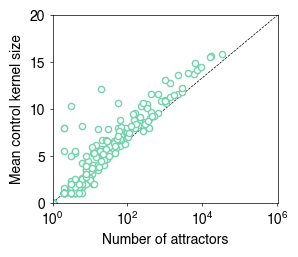

In [89]:
# plot control kernel size with respect to the number of attractors for random networks

plt.figure(figsize=figsize)
plt.scatter(dfExactRandomAll['number of attractors'],
            dfExactRandomAll['mean control kernel size'],
            s=markersize,
            label='Actual CK size',
            c='w',
            edgecolors=colors1['random'])

plt.xlabel('Number of attractors')
plt.ylabel('Mean control kernel size')
plt.xscale('log')
plt.plot([2**minsize,2**maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
#plt.legend()
plt.axis(xmin=2**minsize,xmax=2**maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
makePretty()
plt.savefig('240125_ck_size_vs_num_attractors_random.pdf')

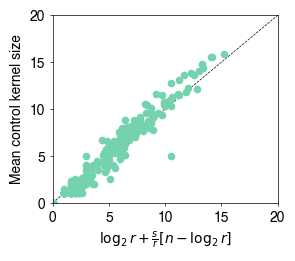

In [90]:
# plot actual ck size versus isolated approximation for random networks

plt.figure(figsize=figsize)
for ck_func in [predict_ck_separate_isolated,]:
    plt.scatter(dfExactRandomAll[ck_func.__name__],
                dfExactRandomAll['mean control kernel size'],
                label=ck_func.__name__,
                s=markersize,
                c=colors1['random']
                )

#plt.xlabel('$\\frac{r-s}{r} \log_2{r} + \\frac{s}{r} n$')
plt.xlabel('$\\log_2{r} + \\frac{s}{r} \\left[ n - \\log_2{r} \\right]$')
plt.ylabel('Mean control kernel size')
minsize,maxsize = 0,20
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
#plt.legend()
makePretty()
plt.savefig('240125_actual_versus_predicted_mean_ck_size_random_networks.pdf')

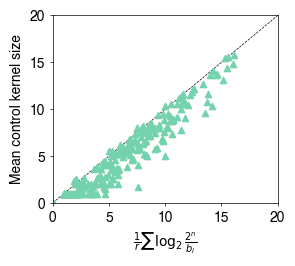

In [100]:
# plot actual ck size versus all-basin approximation for random networks

plt.figure(figsize=figsize)
for ck_func in [predict_ck_all_basins,]:
    plt.scatter(dfExactRandomAll[ck_func.__name__],
                dfExactRandomAll['mean control kernel size'],
                label=ck_func.__name__,
                s=markersize,
                c=colors1['random'],
                marker='^')

#plt.xlabel('$\\frac{r-s}{r} \log_2{r} + \\frac{s}{r} n$')
plt.xlabel('$\\frac{1}{r} \\sum \\log_2 \\frac{2^n}{b_i}$')
plt.ylabel('Mean control kernel size')
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
#plt.legend()
makePretty()
plt.savefig('240125_actual_versus_predicted_mean_ck_size_all_basins_random_networks.pdf')

### Average control kernel size prediction plots — cell collective networks

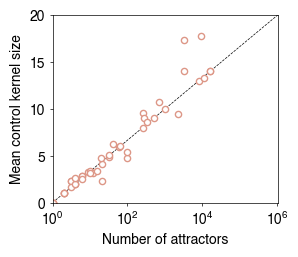

In [92]:
# plot control kernel size with respect to the number of attractors for cell collective networks

plt.figure(figsize=figsize)
plt.scatter(ck_df['number of attractors'],
            ck_df['mean control kernel size'],
            s=markersize,
            label='Actual CK size',
            edgecolors=colors1['cellcollective'],
            c='w')

plt.xlabel('Number of attractors')
plt.ylabel('Mean control kernel size')
plt.xscale('log')
plt.plot([2**minsize,2**maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
#plt.legend()
plt.axis(xmin=2**minsize,xmax=2**maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
makePretty()
plt.savefig('240125_ck_size_vs_num_attractors_cell_collective.pdf')

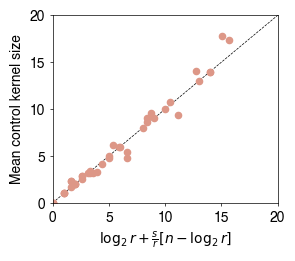

In [93]:
# plot actual ck size versus isolated approximation for cell collective networks

plt.figure(figsize=figsize)
for ck_func in [predict_ck_separate_isolated,]:
    plt.scatter(ck_df[ck_func.__name__],
                ck_df['mean control kernel size'],
                label=ck_func.__name__,
                s=markersize,
                c=colors1['cellcollective'])

#plt.xlabel('$\\frac{r-s}{r} \log_2{r} + \\frac{s}{r} n$')
plt.xlabel('$\\log_2{r} + \\frac{s}{r} \\left[ n - \\log_2{r} \\right]$')
plt.ylabel('Mean control kernel size')
minsize,maxsize = 0,20
plt.plot([minsize,maxsize],[minsize,maxsize],'k--',lw=0.5,zorder=-10)
plt.axis(xmin=minsize,xmax=maxsize,ymin=minsize,ymax=maxsize)
plt.yticks([0,5,10,15,20])
plt.subplots_adjust(bottom=bottom,top=top,left=left,right=right)
#plt.legend()
makePretty()
plt.savefig('240125_actual_versus_predicted_mean_ck_size_cell_collective_networks.pdf')

### Individual attractor plots

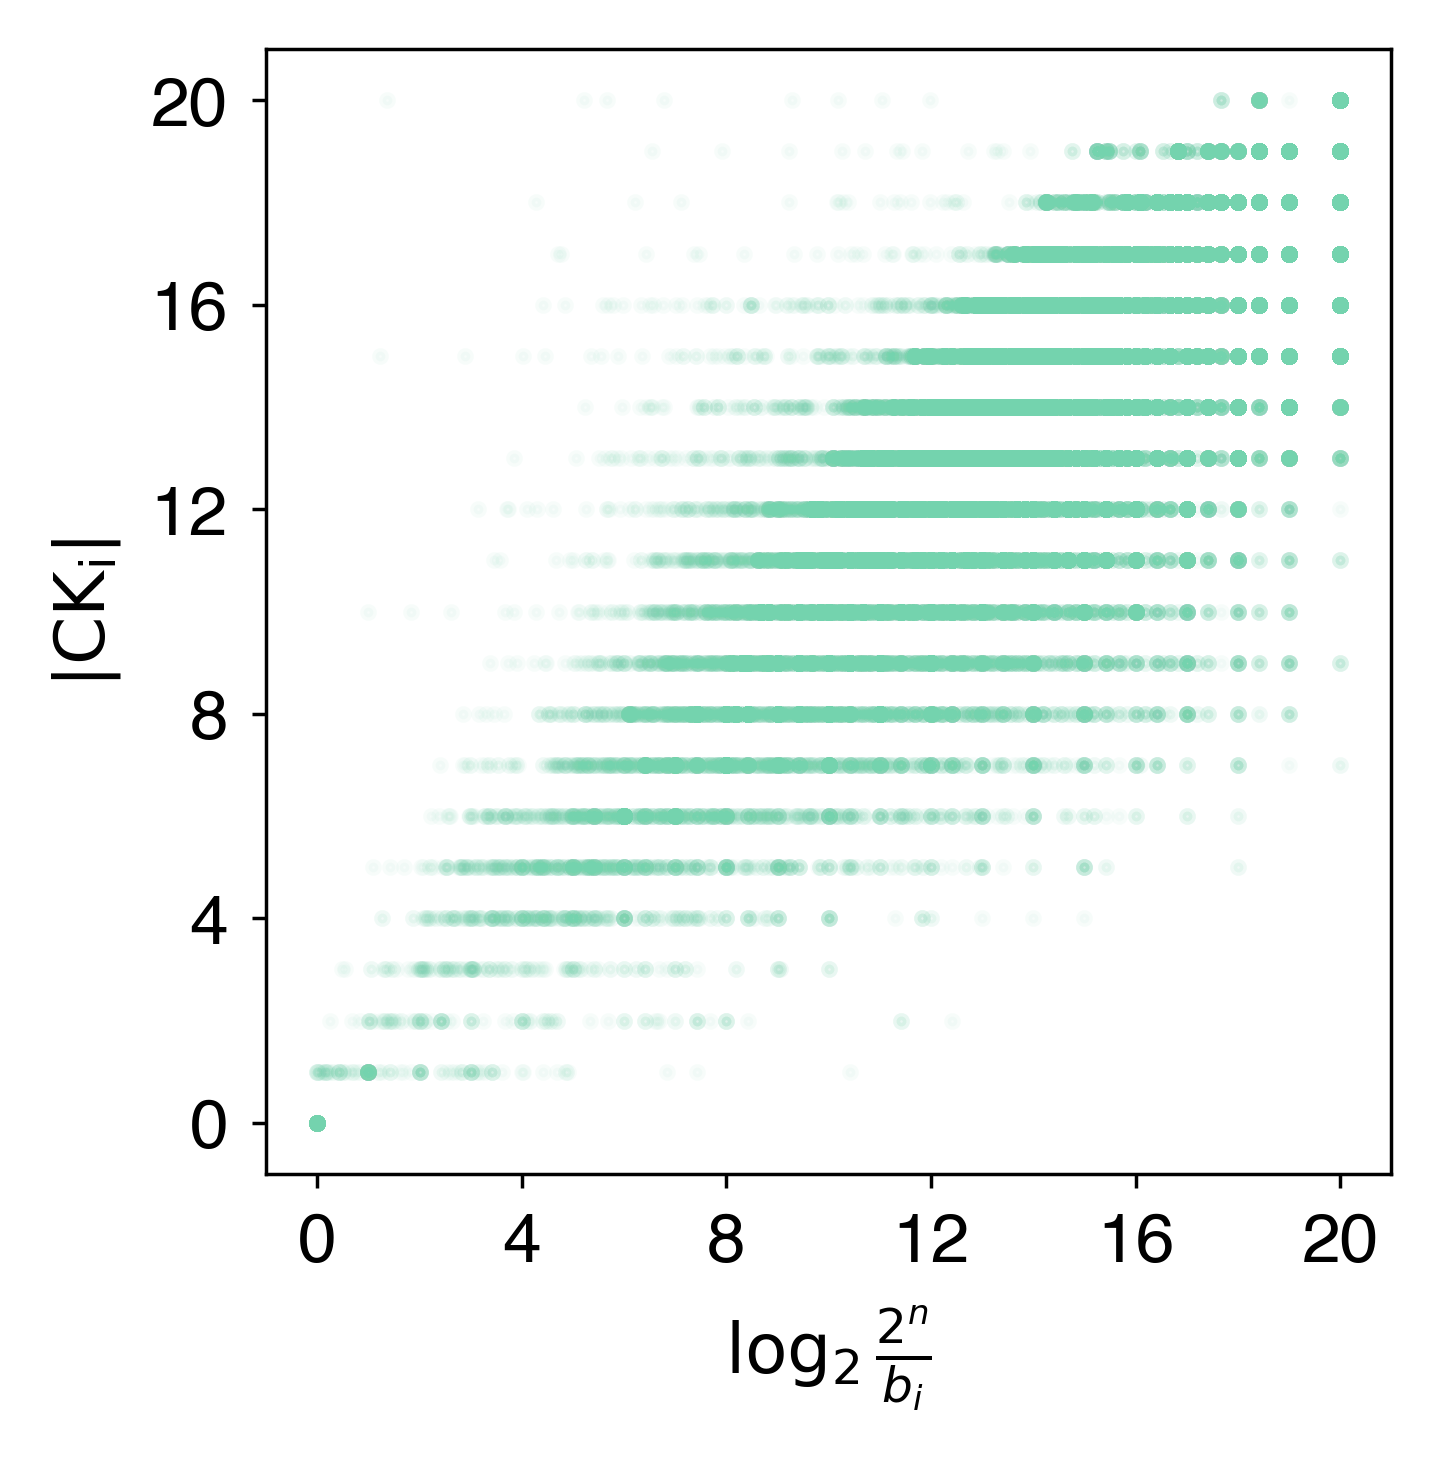

In [95]:
plt.figure(figsize=(3,3),dpi=500)
# plt.hist2d(np.log2(relative_basin_sizes)/net_sizes,
#            relative_ck_sizes,bins=10,cmap=plt.colormaps['RdYlBu']) #,alpha=0.05,s=10)
plt.scatter(-np.log2(relative_basin_sizes),
            absolute_ck_sizes,alpha=0.05,s=2,
            c=colors1['random'])
#plt.xscale('log')
plt.xlabel('$\\log_2{\\frac{2^n}{b_i}}$')
plt.ylabel('$|\mathrm{CK_i}|$')
plt.xticks(range(0,21,4))
plt.yticks(range(0,21,4))
plt.subplots_adjust(bottom=0.2,top=0.95,left=0.2,right=0.95)
makePretty()
plt.savefig('240125_ck_size_vs_relative_basin_size.png')

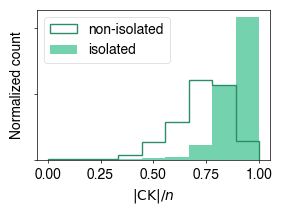

In [52]:
# isolated and non-isolated histograms for all random networks 
plt.figure(figsize=(3,2))

bins = np.linspace(0,1,10)
plt.hist(relative_ck_sizes_nonisolated,density=True,bins=bins,histtype='step',label='non-isolated',
         color=colors1['random dark'])
plt.hist(relative_ck_sizes_isolated,density=True,bins=bins,label='isolated',
         color=colors1['random'])
leg = plt.legend()
plt.yticks([0,2.5,5],[])
plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Normalized count')
plt.subplots_adjust(bottom=0.2,top=0.95)
makePretty(leg=leg)
plt.savefig('240125_ck_histogram_isolated_vs_nonisolated_random.pdf')

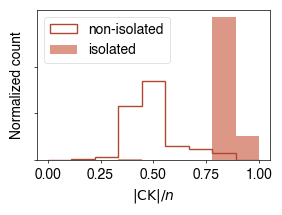

In [53]:
# isolated and non-isolated histograms for cell collective networks 
plt.figure(figsize=(3,2))

bins = np.linspace(0,1,10)
plt.hist(relative_ck_sizes_nonisolated_cc,density=True,bins=bins,histtype='step',label='non-isolated',
         color=colors1['cellcollective dark'])
plt.hist(relative_ck_sizes_isolated_cc,density=True,bins=bins,label='isolated',
         color=colors1['cellcollective'])
leg = plt.legend()
plt.yticks([0,2.5,5],[])
plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Normalized count')
plt.subplots_adjust(bottom=0.2,top=0.95)
makePretty(leg=leg)
plt.savefig('240125_ck_histogram_isolated_vs_nonisolated_cell_collective.pdf')